<a href="https://colab.research.google.com/github/CHATHARABOINASAGAR/NLP-LAB/blob/main/NLP_AS_10_10_2K25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Computing SBERT embeddings (this will be faster & produce better sentence vectors than raw BERT pooling)...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

SBERT matrix shape: (10, 384)
Reducing SBERT...
SBERT 2D ready.
SBERT: silhouette (2D) = 0.39640092849731445, emb_shape = (10, 384)


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


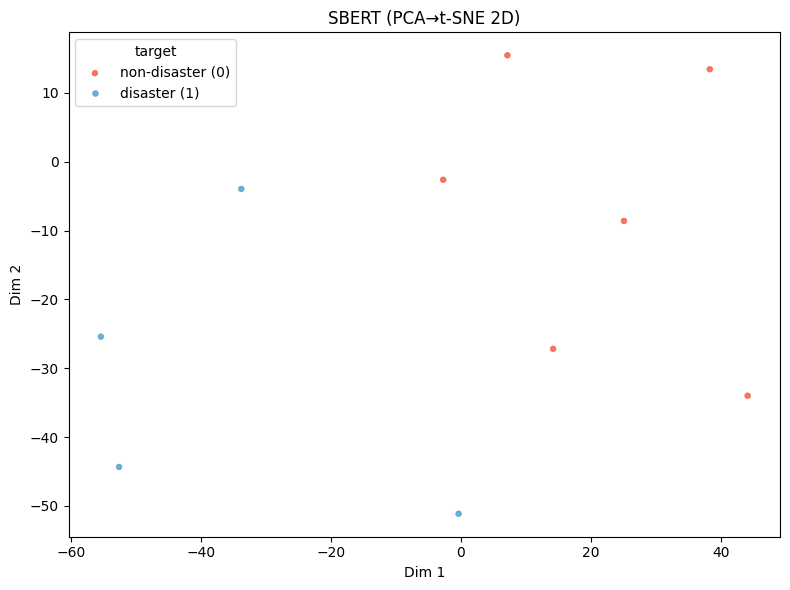


Summary of improvements & numeric scores:
 - SBERT: silhouette_2d=0.39640092849731445, emb_shape=(10, 384)


In [4]:
import os, sys, subprocess, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

texts = [
    "Earthquake destroyed several buildings in the city.",
    "Severe floods affected thousands of people.",
    "The government passed a new economic reform bill.",
    "A volcanic eruption forced evacuations in nearby towns.",
    "Heavy rainfall created landslides in rural areas.",
    "Tech companies announced new AI-powered devices.",
    "Wildfire spread rapidly across the forest region.",
    "Scientists discover new planet in distant galaxy.",
    "Tsunami warnings issued after undersea quake.",
    "Sports team wins championship after final match."
]

labels = [1,1,0,1,1,0,1,0,1,0]

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

try:
    from sentence_transformers import SentenceTransformer
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "sentence-transformers"], stdout=subprocess.DEVNULL)
    from sentence_transformers import SentenceTransformer

SBERT_MODEL = "all-MiniLM-L6-v2"

def compute_sbert_embeddings(texts, model_name=SBERT_MODEL, batch_size=64, device=None):
    model = SentenceTransformer(model_name)
    embs = model.encode(texts, batch_size=batch_size, show_progress_bar=True, convert_to_numpy=True)
    return embs

print("Computing SBERT embeddings (this will be faster & produce better sentence vectors than raw BERT pooling)...")
sbert_vectors = compute_sbert_embeddings(texts, model_name=SBERT_MODEL, batch_size=64)
print("SBERT matrix shape:", sbert_vectors.shape)

def pca_then_tsne(emb_matrix, n_pca=50, tsne_perplexity=30, tsne_iter=1000, random_state=RANDOM_STATE):
    scaler = StandardScaler()
    emb_scaled = scaler.fit_transform(emb_matrix)
    n_pca = min(n_pca, emb_scaled.shape[0], emb_scaled.shape[1])
    pca = PCA(n_components=n_pca, random_state=random_state)
    emb_pca = pca.fit_transform(emb_scaled)
    tsne = TSNE(
        n_components=2,
        perplexity=min(tsne_perplexity, max(5, emb_pca.shape[0] // 5)),
        n_iter=tsne_iter,
        random_state=random_state,
        init='pca'
    )
    emb_2d = tsne.fit_transform(emb_pca)
    return emb_2d

results = {}

print("Reducing SBERT...")
sbert_2d = pca_then_tsne(sbert_vectors, n_pca=50, tsne_iter=750)
results['SBERT'] = (sbert_vectors, sbert_2d)
print("SBERT 2D ready.")

def plot_2d_coords(coords2d, labels, title, outpath):
    xs, ys = coords2d[:, 0], coords2d[:, 1]
    plt.figure(figsize=(8, 6))
    palette = {0: "#2b8cbe", 1: "#f03b20"}
    sns.scatterplot(x=xs, y=ys, hue=labels, palette=palette, alpha=0.7, s=18, edgecolor=None)
    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.legend(title="target", labels=["non-disaster (0)", "disaster (1)"])
    plt.tight_layout()
    os.makedirs(os.path.dirname(outpath), exist_ok=True)
    plt.savefig(outpath, dpi=200)
    plt.show()

summary = {}
for name, (emb, coords) in results.items():
    try:
        sil = silhouette_score(coords, labels)
    except Exception:
        sil = None
    summary[name] = {'silhouette_2d': sil, 'emb_shape': emb.shape, '2d_shape': coords.shape}
    print(f"{name}: silhouette (2D) = {sil}, emb_shape = {emb.shape}")
    outpng = os.path.join("embedding_plots", f"{name}_2d_sbert_fix.png")
    plot_2d_coords(coords, labels, f"{name} (PCA→t-SNE 2D)", outpng)

os.makedirs("embedding_outputs", exist_ok=True)
for name, (emb, coords) in results.items():
    np.save(os.path.join("embedding_outputs", f"{name}_emb.npy"), emb)
    np.save(os.path.join("embedding_outputs", f"{name}_2d.npy"), coords)

print("\nSummary of improvements & numeric scores:")
for name, info in summary.items():
    print(f" - {name}: silhouette_2d={info['silhouette_2d']}, emb_shape={info['emb_shape']}")
